In [1]:
%matplotlib inline


# 7 - Probabilistic data association tutorial


Making an assignment between a single track and a single measurement can be problematic. In the
previous tutorials you may have encountered the phenomenon of *track seduction*. This occurs
when clutter, or other track, points are mis-associated with a prediction. If this happens
repeatedly (as can be the case in high-clutter or low-$p_d$ situations) the track can
deviate significantly from the truth.

Rather than make a firm assignment at each time-step, we could work out the probability that each
measurement should be assigned to a particular target. We could then propagate a measure of
these collective probabilities to mitigate the effect of track seduction.

Pictorially:

- Calculate a posterior for each hypothesis;

<img src="https://stonesoup.rtfd.io/en/v0.1b8/_static/PDA_Hypothesis_Diagram.png" width="500" alt="Image showing NN association for one track">

- Weight each posterior state according to the probability that its corresponding hypothesis
  was true (including the probability of missed-detection);

<img src="https://stonesoup.rtfd.io/en/v0.1b8/_static/PDA_Weighting_Diagram.png" width="500" alt="Image showing NN association for one track">

- Merge the resulting estimate states in to a single posterior approximation.

<img src="https://stonesoup.rtfd.io/en/v0.1b8/_static/PDA_Merge_Diagram.png" width="500" alt="Image showing NN association for one track">

This results in a more robust approximation to the posterior state covariances that incorporates
not only the uncertainty in state, but also in the association.



## A PDA filter example

### Ground truth

So, as before, we'll first begin by simulating some ground truth.



In [2]:
import numpy as np

from datetime import datetime
from datetime import timedelta

from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
                                               ConstantVelocity
from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState

np.random.seed(1991)

start_time = datetime.now()
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.005),
                                                          ConstantVelocity(0.005)])
truth = GroundTruthPath([GroundTruthState([0, 1, 0, 1], timestamp=start_time)])
for k in range(1, 21):
    truth.append(GroundTruthState(
        transition_model.function(truth[k-1], noise=True, time_interval=timedelta(seconds=1)),
        timestamp=start_time+timedelta(seconds=k)))

Add clutter.



In [3]:
from scipy.stats import uniform

from stonesoup.types.detection import TrueDetection
from stonesoup.types.detection import Clutter
from stonesoup.models.measurement.linear import LinearGaussian
measurement_model = LinearGaussian(
    ndim_state=4,
    mapping=(0, 2),
    noise_covar=np.array([[0.75, 0],
                          [0, 0.75]])
    )

prob_detect = 0.9  # 90% chance of detection.

all_measurements = []
for state in truth:
    measurement_set = set()

    # Generate detection.
    if np.random.rand() <= prob_detect:
        measurement = measurement_model.function(state, noise=True)
        measurement_set.add(TrueDetection(state_vector=measurement,
                                          groundtruth_path=truth,
                                          timestamp=state.timestamp,
                                          measurement_model=measurement_model))

    # Generate clutter.
    truth_x = state.state_vector[0]
    truth_y = state.state_vector[2]
    for _ in range(np.random.randint(10)):
        x = uniform.rvs(truth_x - 10, 20)
        y = uniform.rvs(truth_y - 10, 20)
        measurement_set.add(Clutter(np.array([[x], [y]]), timestamp=state.timestamp,
                                    measurement_model=measurement_model))

    all_measurements.append(measurement_set)

Plot the ground truth and measurements with clutter.



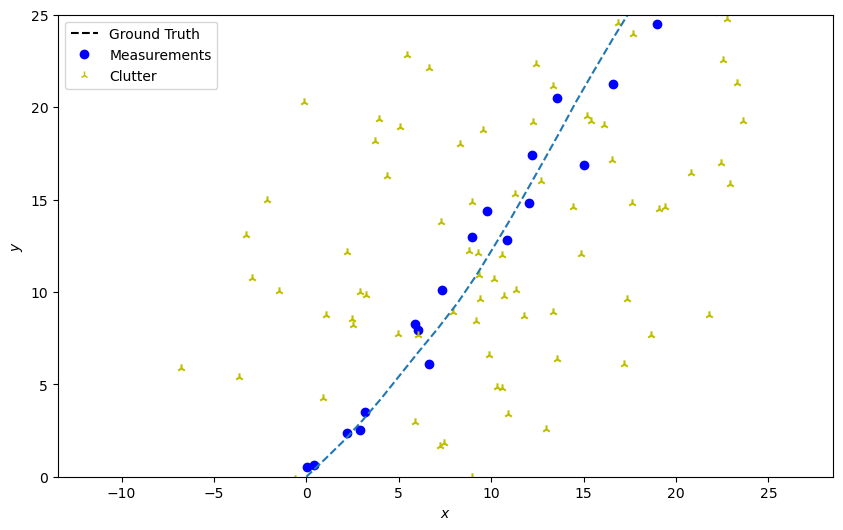

In [4]:
from stonesoup.plotter import Plotter
plotter = Plotter()
plotter.ax.set_ylim(0, 25)
plotter.plot_ground_truths(truth, [0, 2])

# Plot true detections and clutter.
plotter.plot_measurements(all_measurements, [0, 2])

Create the predictor and updater



In [5]:
from stonesoup.predictor.kalman import KalmanPredictor
predictor = KalmanPredictor(transition_model)

from stonesoup.updater.kalman import KalmanUpdater
updater = KalmanUpdater(measurement_model)

### Initialise Probabilistic Data Associator
The :class:`~.PDAHypothesiser` and :class:`~.PDA` associator generate track predictions and
calculate probabilities for all prediction-detection pairs for a single prediction and multiple
detections.
The :class:`~.PDAHypothesiser` returns a collection of :class:`~.SingleProbabilityHypothesis`
types. The :class:`~.PDA` takes these hypotheses and returns a dictionary of key-value pairings
of each track and detection which it is to be associated with.



In [6]:
from stonesoup.hypothesiser.probability import PDAHypothesiser
hypothesiser = PDAHypothesiser(predictor=predictor,
                               updater=updater,
                               clutter_spatial_density=0.125,
                               prob_detect=prob_detect)

from stonesoup.dataassociator.probability import PDA
data_associator = PDA(hypothesiser=hypothesiser)

### Run the PDA Filter

With these components, we can run the simulated data and clutter through the Kalman filter.



In [7]:
# Create prior
from stonesoup.types.state import GaussianState
prior = GaussianState([[0], [1], [0], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=start_time)

# Loop through the predict, hypothesise, associate and update steps.
from stonesoup.types.track import Track
from stonesoup.types.array import StateVectors  # For storing state vectors during association
from stonesoup.functions import gm_reduce_single  # For merging states to get posterior estimate
from stonesoup.types.update import GaussianStateUpdate  # To store posterior estimate

track = Track([prior])
for n, measurements in enumerate(all_measurements):
    hypotheses = data_associator.associate({track},
                                           measurements,
                                           start_time + timedelta(seconds=n))

    hypotheses = hypotheses[track]

    # Loop through each hypothesis, creating posterior states for each, and merge to calculate
    # approximation to actual posterior state mean and covariance.
    posterior_states = []
    posterior_state_weights = []
    for hypothesis in hypotheses:
        if not hypothesis:
            posterior_states.append(hypothesis.prediction)
        else:
            posterior_state = updater.update(hypothesis)
            posterior_states.append(posterior_state)
        posterior_state_weights.append(
            hypothesis.probability)

    means = StateVectors([state.state_vector for state in posterior_states])
    covars = np.stack([state.covar for state in posterior_states], axis=2)
    weights = np.asarray(posterior_state_weights)

    # Reduce mixture of states to one posterior estimate Gaussian.
    post_mean, post_covar = gm_reduce_single(means, covars, weights)

    # Add a Gaussian state approximation to the track.
    track.append(GaussianStateUpdate(
        post_mean, post_covar,
        hypotheses,
        hypotheses[0].measurement.timestamp))

Plot the resulting track



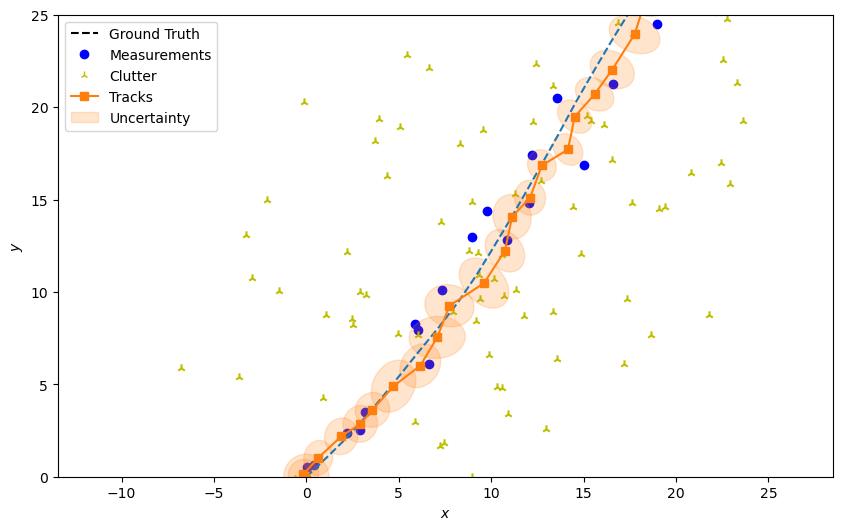

In [8]:
plotter.plot_tracks(track, [0, 2], uncertainty=True)
plotter.fig

## References
1. Bar-Shalom Y, Daum F, Huang F 2009, The Probabilistic Data Association Filter, IEEE Control
Systems Magazine

